In [ ]:
import pandas as pd
from utils.plotting import plot_time, plot_iter, plot_trajectories

**Read results:**

In [ ]:
import os


TASK = "income"
STATE = "OK"
DATASET = TASK + "_" + STATE
lb = 0.005
constraint = "eq_loss"

algs = ['SSLALM', 'ALM', 'StochasticGhost', 'SGD', 'fairret', 'a05', 'a01']
stats = dict.fromkeys(algs)
results_dir = './utils/exp_results/'

for alg in algs:
    filename = os.path.join(results_dir, f"{alg}_" + f"{DATASET}_{lb}.csv")
    try:
        stats[alg] = pd.read_csv(filename)
    except:
        print(f'{alg} not found in {results_dir}')

In [ ]:
stats_train = {alg: s[s["is_train"] == "train"].drop(["is_train"], axis=1).dropna() for alg, s in stats.items() if s is not None}
stats_test = {alg: s[s["is_train"] == "test"].drop(["is_train"], axis=1).dropna() for alg, s in stats.items() if s is not None}

## Plots w.r.t. time

### SSL-ALM

**Train**

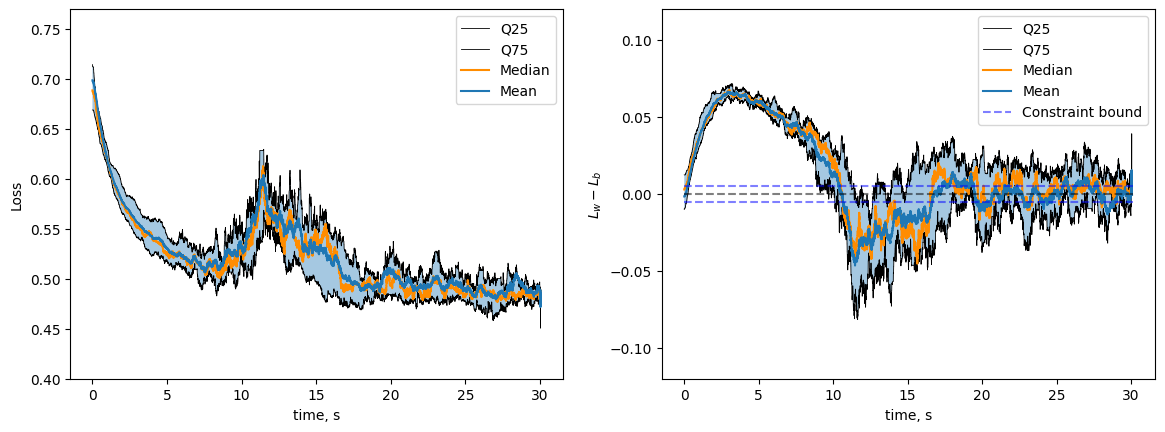

In [ ]:
alg = 'SSLALM'
os.makedirs(os.path.dirname(f"./plots/{alg}/{DATASET}/"), exist_ok=True)

f1tr_time = plot_time(
    stats_train[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.12)
)

In [ ]:
f1tr_time.savefig(
    f"./plots/{alg}/{DATASET}/train_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}/train_time_{DATASET}")

./plots/SSLALM/income_OK/train_time_income_OK


**Test**

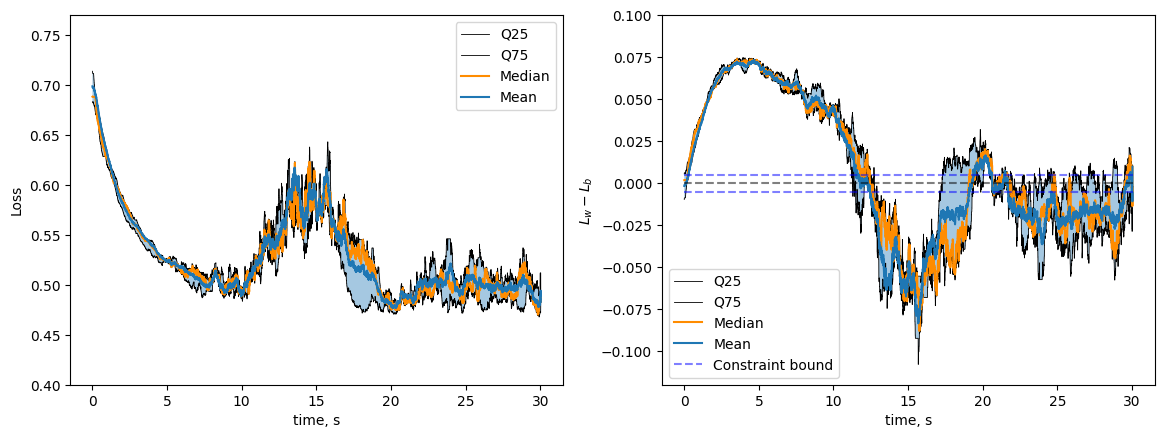

In [ ]:
f1t_time = plot_time(
    stats_test[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.1)
)

In [ ]:
f1t_time.savefig(
    f"./plots/{alg}/{DATASET}/test_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}")

./plots/SSLALM/income_OK


### ALM

**Train**

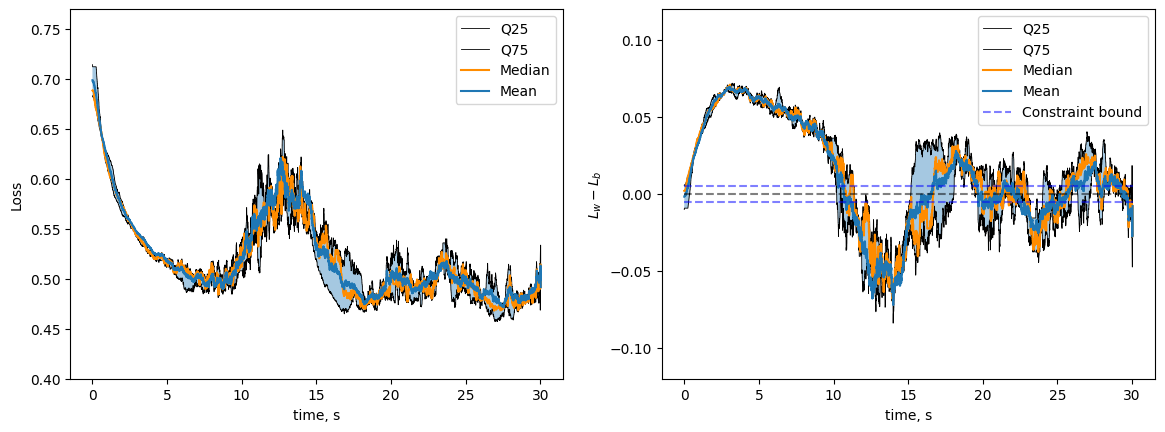

In [ ]:
alg = 'ALM'
os.makedirs(os.path.dirname(f"./plots/{alg}/{DATASET}/"), exist_ok=True)

f1tr_time = plot_time(
    stats_train[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.12)
)

In [ ]:
f1tr_time.savefig(
    f"./plots/{alg}/{DATASET}/train_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}/train_time_{DATASET}")

./plots/ALM/income_OK/train_time_income_OK


**Test**

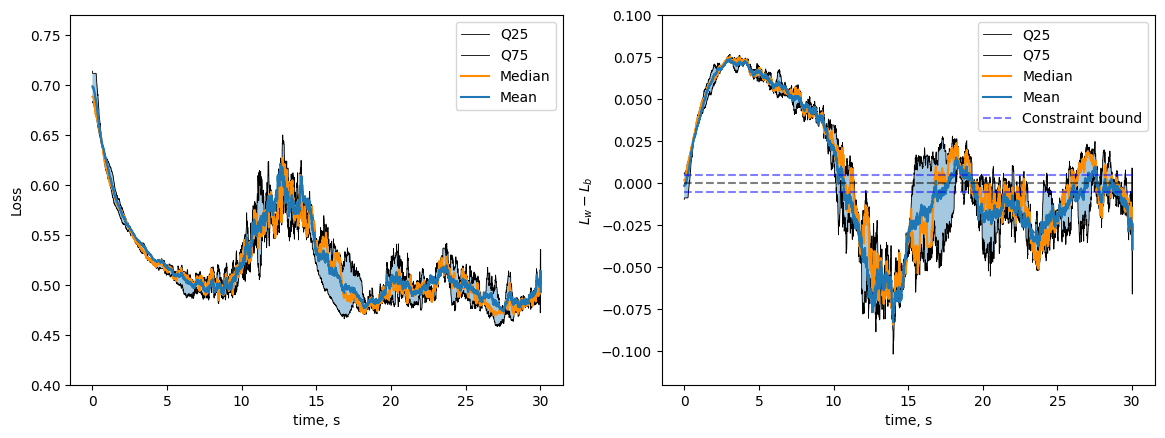

In [ ]:
f1t_time = plot_time(
    stats_test[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.1)
)

In [ ]:
f1t_time.savefig(
    f"./plots/{alg}/{DATASET}/test_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}")

./plots/ALM/income_OK


### Ghost

**Train**

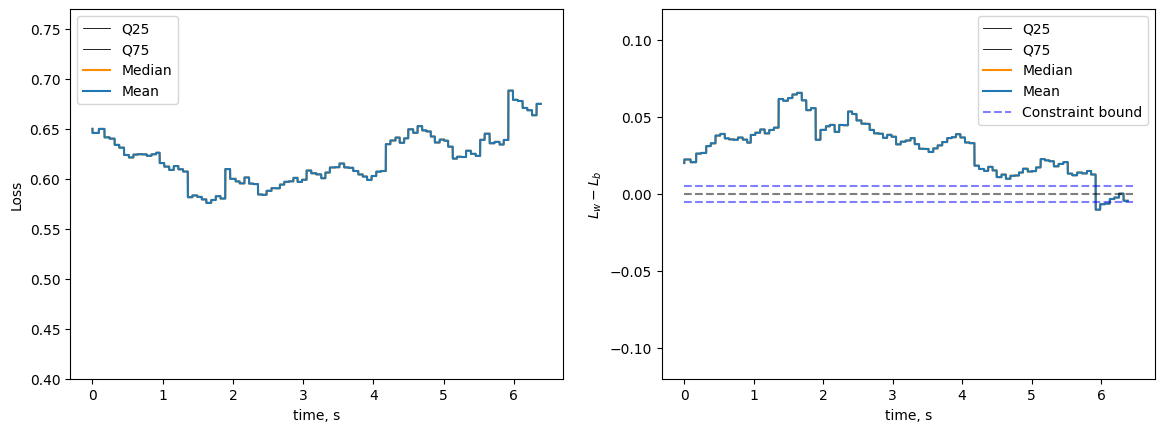

In [ ]:
alg = 'StochasticGhost'
os.makedirs(os.path.dirname(f"./plots/{alg}/{DATASET}/"), exist_ok=True)

f1tr_time = plot_time(
    stats_train[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.12)
)

In [ ]:
f1tr_time.savefig(
    f"./plots/{alg}/{DATASET}/train_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}/train_time_{DATASET}")

./plots/StochasticGhost/income_OK/train_time_income_OK


**Test**

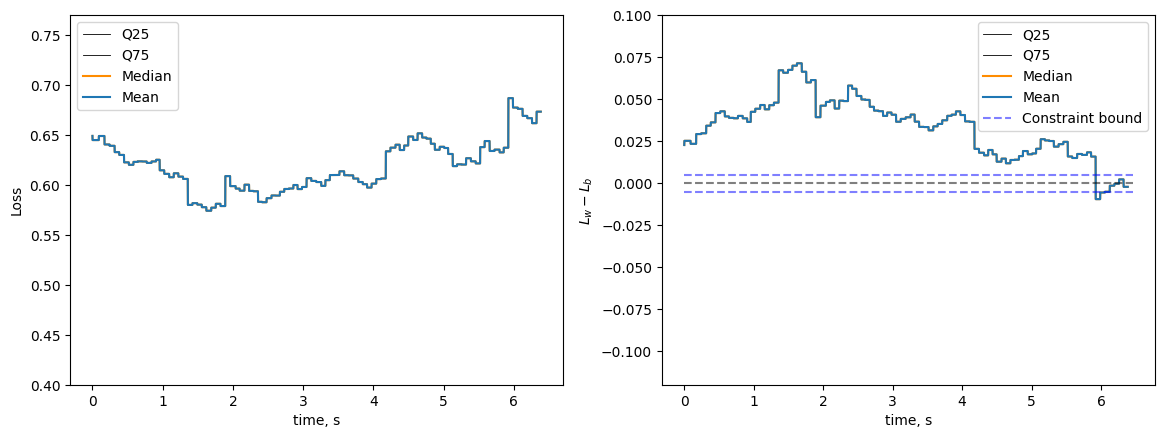

In [ ]:
f1t_time = plot_time(
    stats_test[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.1)
)

In [ ]:
f1t_time.savefig(
    f"./plots/{alg}/{DATASET}/test_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}")

./plots/StochasticGhost/income_OK


### SGD

**Train**

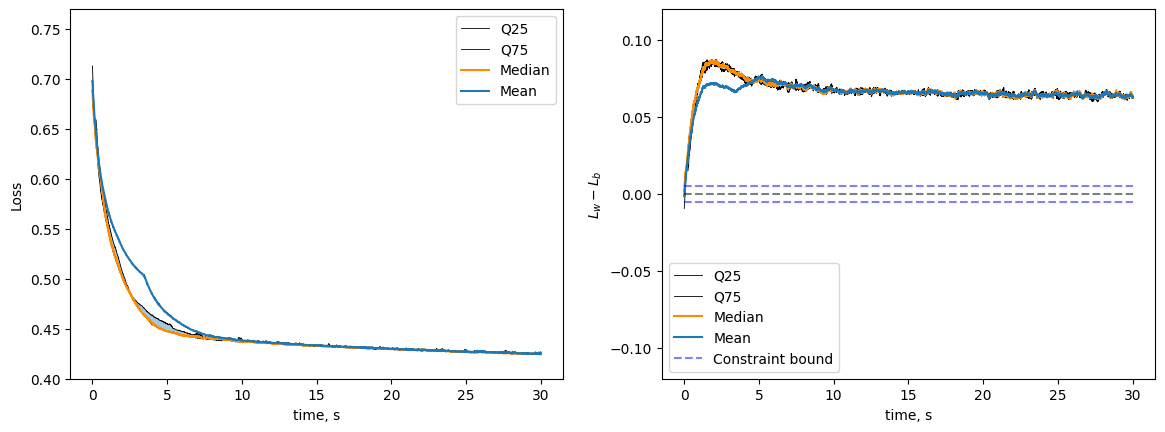

In [ ]:
alg = 'SGD'
os.makedirs(os.path.dirname(f"./plots/{alg}/{DATASET}/"), exist_ok=True)

f1tr_time = plot_time(
    stats_train[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.12)
)

In [ ]:
f1tr_time.savefig(
    f"./plots/{alg}/{DATASET}/train_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}/train_time_{DATASET}")

./plots/SGD/income_OK/train_time_income_OK


**Test**

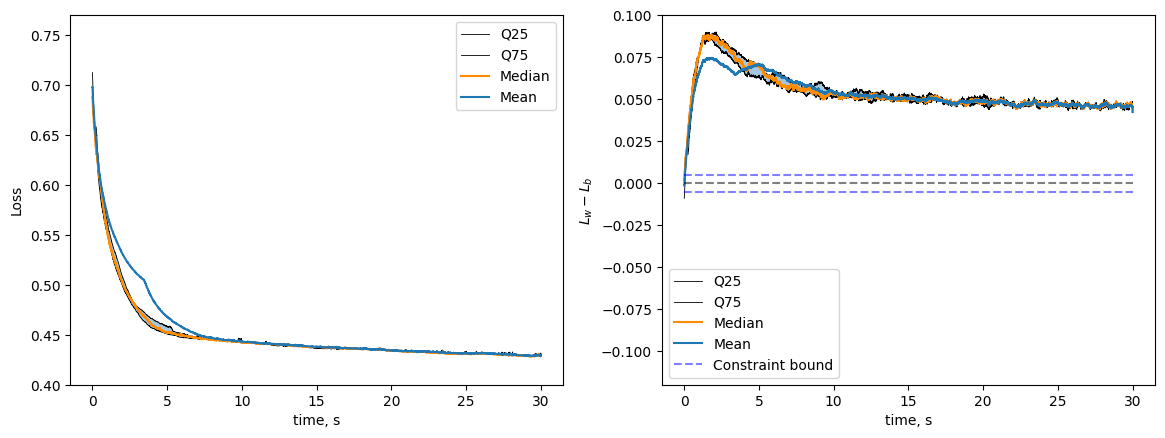

In [ ]:
f1t_time = plot_time(
    stats_test[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.1)
)

In [ ]:
f1t_time.savefig(
    f"./plots/{alg}/{DATASET}/test_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}")

./plots/SGD/income_OK


### Fairret

**Train**

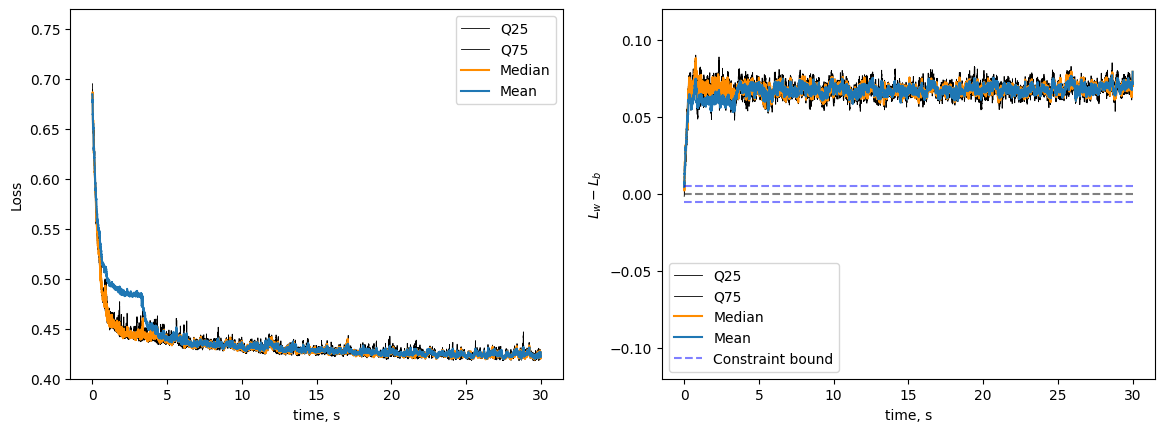

In [ ]:
alg = 'fairret'
os.makedirs(os.path.dirname(f"./plots/{alg}/{DATASET}/"), exist_ok=True)

f1tr_time = plot_time(
    stats_train[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.12)
)

In [ ]:
f1tr_time.savefig(
    f"./plots/{alg}/{DATASET}/train_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}/train_time_{DATASET}")

./plots/fairret/income_OK/train_time_income_OK


**Test**

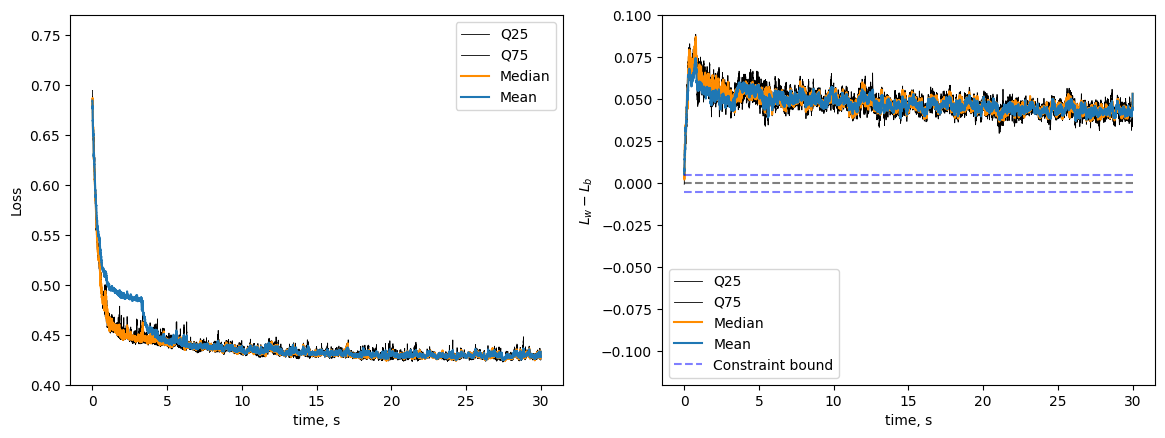

In [ ]:
f1t_time = plot_time(
    stats_test[alg], lb, round_step=0.0005, f_ylim=(0.4, 0.77), c_ylim=(-0.12, 0.1)
)

In [ ]:
f1t_time.savefig(
    f"./plots/{alg}/{DATASET}/test_time_{DATASET}"
)
print(f"./plots/{alg}/{DATASET}")

./plots/fairret/income_OK


## Plots w.r.t. iteration

In [ ]:
alg = 'SSLALM'

**Train**

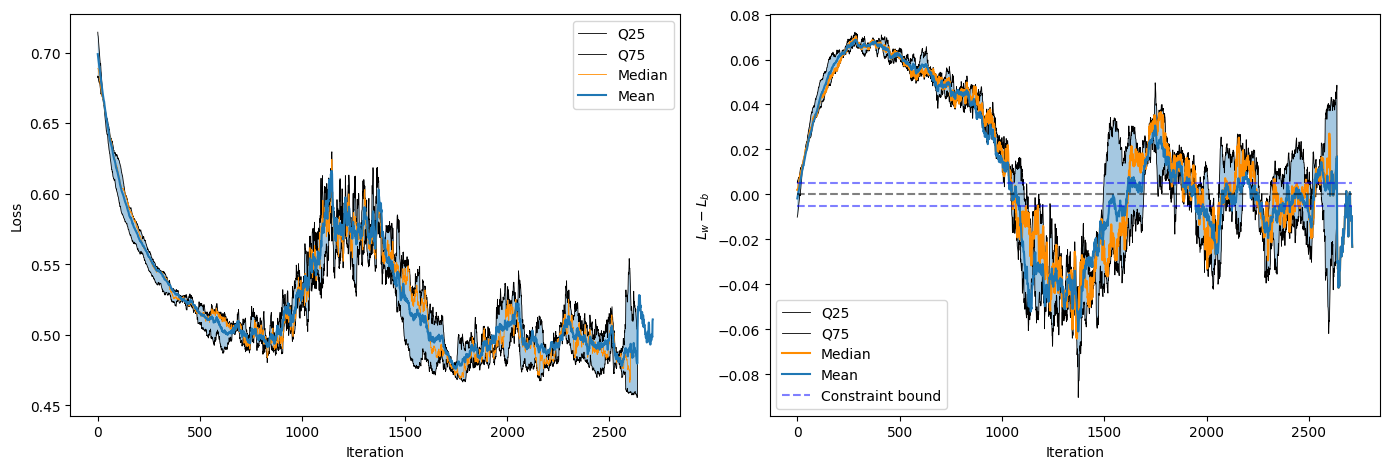

In [ ]:
f1tr = plot_iter(stats_train[alg], lb, "iteration")

**Test**

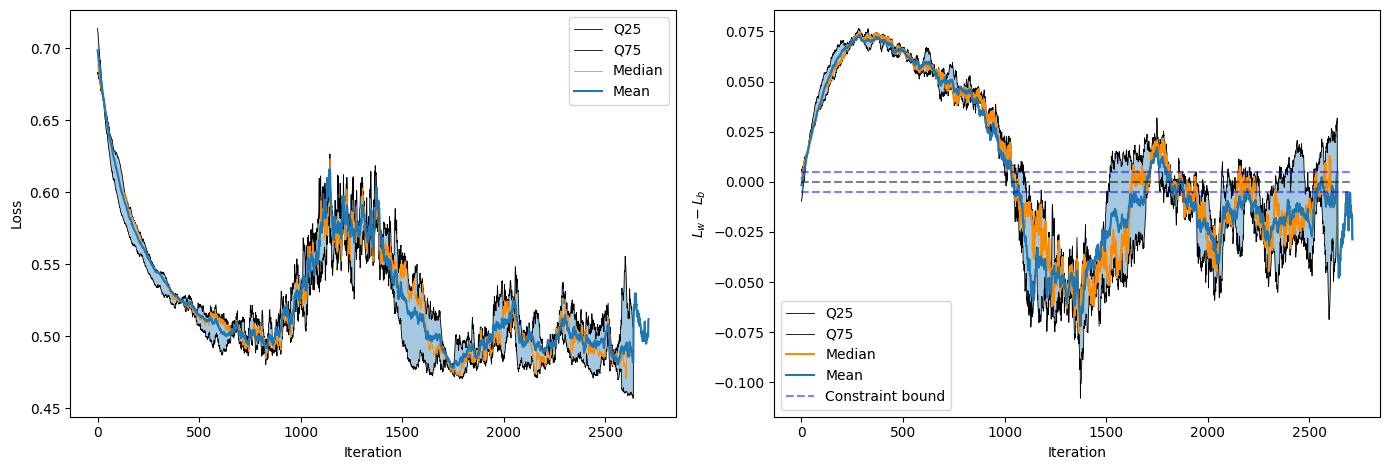

In [ ]:
f1t = plot_iter(stats_test[alg], lb, "iteration")

**Trajectories:**

In [ ]:
alg = 'SSLALM'

**Train**

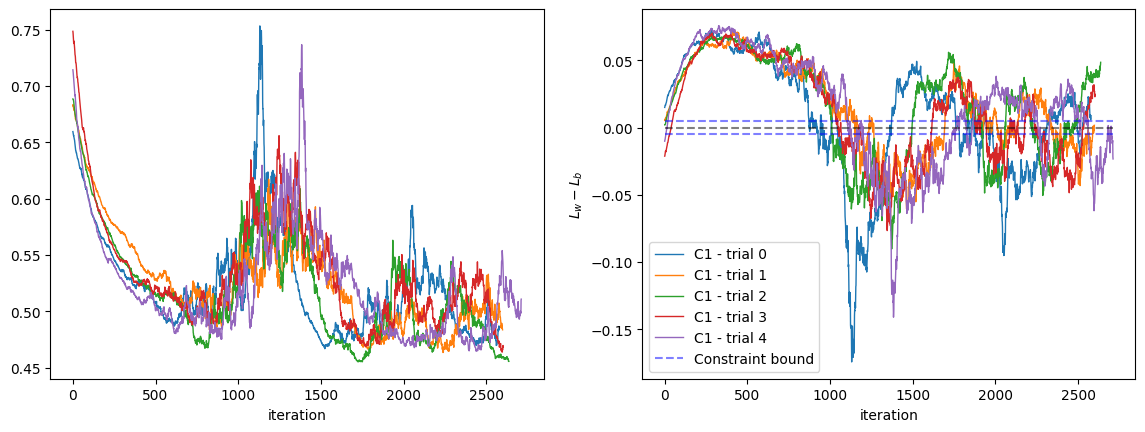

In [ ]:
traj = plot_trajectories(stats_train[alg], lb, "iteration", alpha=1)

**Test**

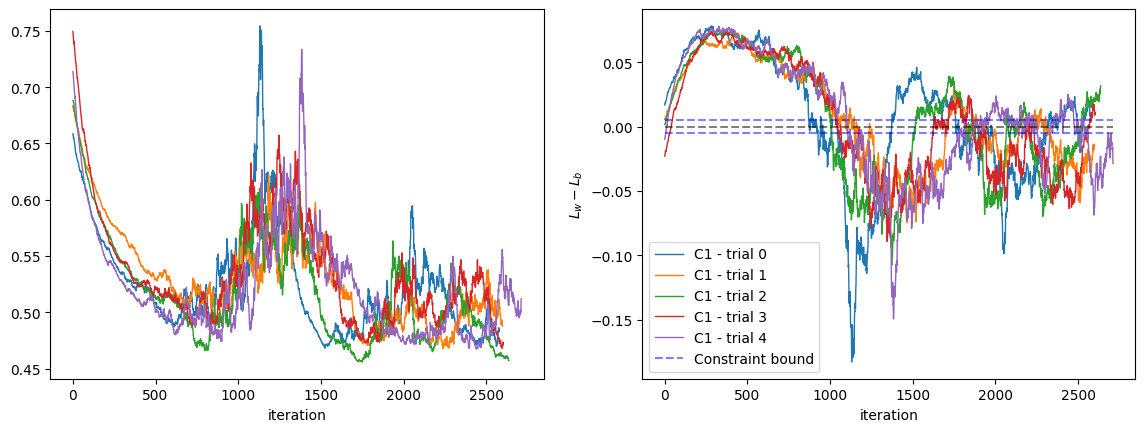

In [ ]:
traj = plot_trajectories(stats_test[alg], lb, "iteration", alpha=1)